<font color="green">*To start working on this notebook, or any other notebook that we will use in the Moringa Data Science Course, we will need to save our own copy of it. We can do this by clicking File > Save a Copy in Drive. We will then be able to make edits to our own copy of this notebook.*</font>

# Python Programming: Logistic Regression

## Importing Our Libraries

In [ ]:
# Importing our libraries
#
import pandas as pd
import seaborn as sb
import numpy as np

## Example 

In [ ]:
# Example 1
# ---
# You are tasked to complete the analysis of what sorts of people were likely to survive the titanic. 
# Specifically you are requested to apply logistic regression modelining 
# to predict which passengers survived the tragedy.
# ---
# Dataset url = http://bit.ly/TitanicTrainDataset
# ---
# Survived - Survival (0 = No; 1 = Yes)
# Pclass - Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
# Name - Name
# Sex - Sex
# Age - Age
# SibSp - Number of Siblings/Spouses Aboard
# Parch - Number of Parents/Children Aboard
# Ticket - Ticket Number
# Fare - Passenger Fare (British pound)
# Cabin - Cabin
# Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

In [ ]:
# Reading in the dataset using the Pandas
# 
titanic = pd.read_csv("http://bit.ly/TitanicTrainDataset")
titanic.columns = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


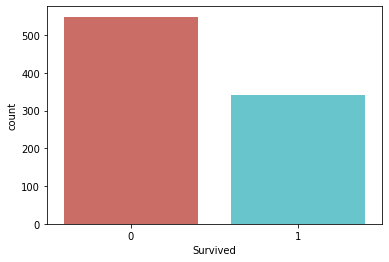

In [ ]:
# Checking that our target variable is binary
# Since we are building a model to predict survival of passangers from the Titanic, 
# our target is going to be "Survived" variable from the titanic dataframe. 
# To make sure that it's a binary variable, let's use Seaborn's countplot() function.
# 
sb.countplot(x='Survived',data=titanic, palette='hls')

# from the output we see that the Survived variable is binary (0 - did not survive / 1 - survived)

In [ ]:
# Checking for missing values
# 
titanic.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
# Understanding the dataset abit more
# 
titanic.info()

# Ok, so there are only 891 rows in the titanic data frame. 
# Cabin is almost all missing values, so we can drop that variable completely, 
# but what about age? Age seems like a relevant predictor for survival right? 
# We'd want to keep the variables, but it has 177 missing values.
# We are going to need to find a way to approximate for those missing values!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# Taking care of missing values
# So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:
# ---
# Survived - This variable is obviously relevant.
# Pclass - Does a passenger's class on the boat affect their survivability?
# Sex - Could a passenger's gender impact their survival rate?
# Age - Does a person's age impact their survival rate?
# SibSp - Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
# Parch - Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
# Fare - Does the fare a person paid effect his survivability? Maybe - let's keep it.
# Embarked - Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.
# What about a person's name, ticket number, and passenger ID number? They're irrelavant for predicting survivability. 
# And as we recall, the cabin variable is almost all missing values, so we can just drop all of these.
# 
titanic_data = titanic.drop(['PassengerId','Name','Ticket','Cabin'], 1)
titanic_data.head()

# Now we have the dataframe reduced down to only relevant variables, but now we need to deal with the missing values in the age variable.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  from ipykernel import kernelapp as app


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


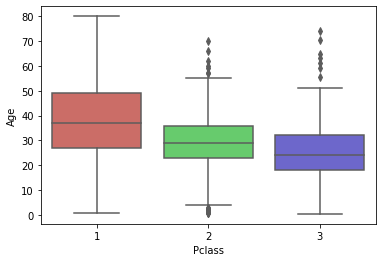

In [ ]:
# Imputing missing values
# ---
# Let's look at how passenger age is related to their class as a passenger on the boat.
# 
sb.boxplot(x='Pclass', y='Age', data=titanic_data, palette='hls')

In [ ]:
titanic_data.head()

# Speaking roughly, we could say that the younger a passenger is, the more likely it is for them to be in 3rd class. 
# The older a passenger is, the more likely it is for them to be in 1st class. 
# So there is a loose relationship between these variables. 
# So, let's write a function that approximates a passengers age, based on their class. 
# From the box plot, it looks like the average age of 1st class passengers 
# is about 37, 2nd class passengers is 29, and 3rd class pasengers is 24.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
# So let's write a function that finds each null value in the Age variable, and for each null, 
# checks the value of the Pclass and assigns an age value according to the average age of passengers in that class.
#
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 37
        elif Pclass == 2:
            return 29
        else:
            return 24
    else:
        return Age

In [ ]:
# When we apply the function and check again for null values, we see that there are no more null values in the age variable.
#
titanic_data['Age'] = titanic_data[['Age', 'Pclass']].apply(age_approx, axis=1)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [ ]:
# There are 2 null values in the embarked variable. We can drop those 2 records 
# without loosing too much important information from our dataset, so we will do that.
#
titanic_data.dropna(inplace=True)
titanic_data.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [ ]:
# Converting categorical variables to a dummy indicators
# ---
# The next thing we need to do is reformat our variables so that they work with the model. 
# Specifically, we need to reformat the Sex and Embarked variables into numeric variables.
#
gender = pd.get_dummies(titanic_data['Sex'],drop_first=True)
gender.head()

,male
0,1
1,0
2,0
3,0
4,1


In [ ]:
embark_location = pd.get_dummies(titanic_data['Embarked'],drop_first=True)
embark_location.head()

,Q,S
0,0,1
1,0,0
2,0,1
3,0,1
4,0,1


In [ ]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [ ]:
titanic_data.drop(['Sex', 'Embarked'],axis=1,inplace=True)
titanic_data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


In [ ]:
titanic_dmy = pd.concat([titanic_data,gender,embark_location],axis=1)
titanic_dmy.head()

# Now we have a dataset with all the variables in the correct format!

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,1,0,1
1,1,1,38.0,1,0,71.2833,0,0,0
2,1,3,26.0,0,0,7.9250,0,0,1
3,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,35.0,0,0,8.0500,1,0,1


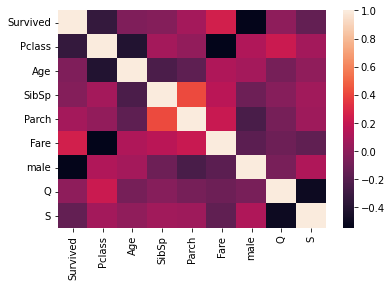

In [ ]:
# Checking for independence between features¶
# 
sb.heatmap(titanic_dmy.corr())  

In [ ]:
# Fare and Pclass are not independent of each other, so I am going to drop these.
# 
titanic_dmy.drop(['Fare', 'Pclass'],axis=1,inplace=True)
titanic_dmy.head()

,Survived,Age,SibSp,Parch,male,Q,S
0,0,22.0,1,0,1,0,1
1,1,38.0,1,0,0,0,0
2,1,26.0,0,0,0,0,1
3,1,35.0,1,0,0,0,1
4,0,35.0,0,0,1,0,1


In [ ]:
# Checking that your dataset size is sufficient
# We have 6 predictive features that remain. The rule of thumb is 50 records per feature 
# so we need to have at least 300 records in this dataset. Let's check again.
#
titanic_dmy.info()

              
# From the output we have 889 records so we are fine.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Age       889 non-null    float64
 2   SibSp     889 non-null    int64  
 3   Parch     889 non-null    int64  
 4   male      889 non-null    uint8  
 5   Q         889 non-null    uint8  
 6   S         889 non-null    uint8  
dtypes: float64(1), int64(3), uint8(3)
memory usage: 37.3 KB


In [ ]:
# Splitting our dataset
#
X = titanic_dmy.drop("Survived",axis=1)
y = titanic_dmy["Survived"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [ ]:
# Fitting our model
# 
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Using our model to make a prediction
#
y_pred = LogReg.predict(X_test)
y_pred

array([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 1])

In [ ]:
# comparing the test and predicted
comparison_frame = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_frame.head(10)

,Actual,Predicted
759,1,1
874,1,1
267,1,0
506,1,1
543,1,0
170,0,0
190,1,1
359,1,1
690,1,0
667,0,0


In [ ]:
# describe
comparison_frame.describe()

,Actual,Predicted
count,267.000000,267.000000
mean,0.385768,0.359551
std,0.487690,0.480770
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [ ]:
# Evaluating the model
#
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

# The results from the confusion matrix tell us that 137 and 69 are the number of correct predictions. 
# 34 and 27 are the number of incorrect predictions.

array([[137,  27],
       [ 34,  69]])

In [ ]:
mean = titanic_dmy["Survived"].mean()
print(mean)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
x = 0.1*mean
print(x)
if rmse >x:
  print("The model/algorithm is not Accurate")
else:
  print("The model/algorithm is Accurate")

0.38245219347581555
0.03824521934758156
The model/algorithm is not Accurate


## <font color="green">Challenge 1</font>

In [ ]:
# Challenge 1
# ---
# Question: Use the Iris dataset to build a regression model to predict the type of iris flower
# ---
# Dataset 
url = 'http://bit.ly/IrisDataset'

iris = pd.read_csv(url)
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [ ]:
# Understanding the data
iris.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

> The data is clean and fit for our analysis

In [ ]:
# Understanding the data
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
# Understanding the data
iris.species.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [ ]:
# changing the data for species columns
cleanup_nums = {"species": {"Iris-setosa": 1, "Iris-versicolor": 2, "Iris-virginica":3 }}
iris_df = iris.replace(cleanup_nums)  
iris_df.head()          

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,1
1,4.9,3.0,1.4,0.2,1
2,4.7,3.2,1.3,0.2,1
3,4.6,3.1,1.5,0.2,1
4,5.0,3.6,1.4,0.2,1


In [ ]:
# Understanding the data
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


Text(0.5, 1.0, 'Heatmap')

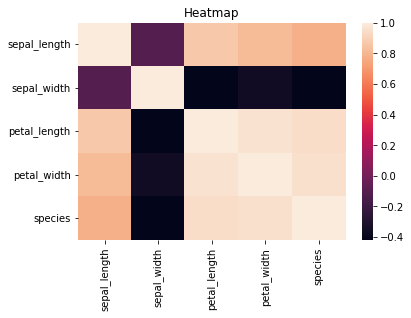

In [ ]:
# Visualizing the correlations
import matplotlib.pyplot as plt
sb.heatmap(iris_df.corr()) 
plt.title("Heatmap") 

In [ ]:
# Splitting our dataset

X = iris_df.drop("species",axis=1)
y = iris_df["species"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [ ]:
# Training/ Fitting  the data set
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
# Using our model to make a prediction
#
y_pred = LogReg.predict(X_test)
y_pred

array([3, 2, 1, 3, 1, 3, 1, 2, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 1, 1, 3, 2,
       1, 1, 3, 1, 1, 2, 2, 1])

In [ ]:
# comparing the test and predicted
comparison_frame = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_frame.head(10)

,Actual,Predicted
114,3,3
62,2,2
33,1,1
107,3,3
7,1,1
100,3,3
40,1,1
86,2,2
76,2,2
71,2,2


In [ ]:
# describe
comparison_frame.describe()

,Actual,Predicted
count,30.000000,30.000000
mean,1.833333,1.833333
std,0.746640,0.746640
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,2.000000,2.000000
max,3.000000,3.000000


In [ ]:
# Evaluating the model
#
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' , accuracy_score(y_test, y_pred))
# The results from the confusion matrix tell us that 30 out of 30 are the number of correct predictions. 
# Accuracy score is 100%

[[11  0  0]
 [ 0 13  0]
 [ 0  0  6]]
Accuracy 1.0


In [ ]:
from sklearn import metrics

# Our first metric is MAE - Mean absolute error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

# We can also use MSE - Mean squared error
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  

# Finally, the most popular metric: RMSE - Root mean squared error
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

mean = iris_df["species"].mean()
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
x = 0.1*mean
if rmse >x:
  print("The model/algorithm is not Accurate")
else:
  print("The model/algorithm is Accurate")

Mean Absolute Error: 0.0
Mean Squared Error: 0.0
Root Mean Squared Error: 0.0
The model/algorithm is Accurate


## <font color="green">Challenge 2</font>

In [ ]:
# Challenge 2
# ---
# Question: Create a regression model that can predict whether an application will be admitted to the university or not.
# ---
# Dataset 
# url = 'http://bit.ly/MarksDataset'
df = pd.read_csv("https://raw.githubusercontent.com/animesh-agarwal/Machine-Learning/master/LogisticRegression/data/marks.txt",header=None, names=['score1','score2','admission'])
df.head()


,score1,score2,admission
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [ ]:
# Understanding the data
df.isnull().sum()

score1       0
score2       0
admission    0
dtype: int64

In [ ]:
# Understanding the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score1     100 non-null    float64
 1   score2     100 non-null    float64
 2   admission  100 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


In [ ]:
# Understanding the data
df.admission.unique()

array([0, 1])

Text(0.5, 1.0, 'Heatmap')

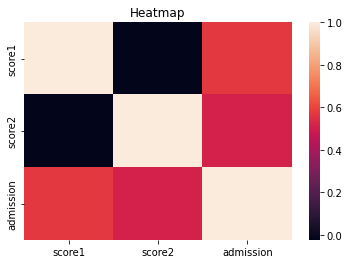

In [ ]:
# Visualizing the correlations
sb.heatmap(df.corr()) 
plt.title("Heatmap") 

In [ ]:
# Splitting our dataset

X = df.drop("admission",axis=1)
y = df["admission"]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [ ]:
# Training/ Fitting  the data set
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Using our model to make a prediction
#
y_pred = LogReg.predict(X_test)
y_pred

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1])

In [ ]:
# comparing the test and predicted
comparison_frame = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_frame.head(10)

,Actual,Predicted
26,1,0
86,0,0
2,0,0
55,0,0
75,1,1
93,1,1
16,1,0
73,1,1
54,0,0
95,1,1


In [ ]:
# describe
comparison_frame.describe()

,Actual,Predicted
count,20.000000,20.000000
mean,0.600000,0.400000
std,0.502625,0.502625
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [ ]:
# Evaluating the model
#
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' , accuracy_score(y_test, y_pred))
# The results from the confusion matrix tell us that 16 out of 20 are the number of correct predictions. 
# Accuracy score is 80%

[[8 0]
 [4 8]]
Accuracy 0.8


In [ ]:
# Checking accuracy of the model
from sklearn import metrics

# Our first metric is MAE - Mean absolute error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

# We can also use MSE - Mean squared error
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  

# Finally, the most popular metric: RMSE - Root mean squared error
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

mean = df["admission"].mean()
print(mean)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
x = 0.1*mean
if rmse >x:
  print("The model/algorithm is not Accurate")
else:
  print("The model/algorithm is Accurate")

Mean Absolute Error: 0.2
Mean Squared Error: 0.2
Root Mean Squared Error: 0.4472135954999579
0.6
The model/algorithm is not Accurate


## <font color="green">Challenge 3</font>

In [ ]:
# Challenge 3
# ---
# Question: Predict if the client will subscribe a term deposit (variable y).
# ---
# Dataset 
url = 'http://bit.ly/BankingDataset'
bank = pd.read_csv(url)
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [ ]:
# Understanding the data
bank.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [ ]:
# Understanding the data
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

In [ ]:
# Understanding the data
print("job",bank.job.unique())
print("marital",bank.marital.unique())
print("education",bank.education.unique())
print("default",bank.default.unique())
print("housing",bank.housing.unique())
print("loan",bank.loan.unique())
print("contact",bank.contact.unique())
print("month",bank.month.unique())
print("day_of_week",bank.day_of_week.unique())

job ['blue-collar' 'technician' 'management' 'services' 'retired' 'admin.'
 'housemaid' 'unemployed' 'entrepreneur' 'self-employed' 'unknown'
 'student']
marital ['married' 'single' 'divorced' 'unknown']
education ['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']
default ['unknown' 'no' 'yes']
housing ['yes' 'no' 'unknown']
loan ['no' 'yes' 'unknown']
contact ['cellular' 'telephone']
month ['aug' 'nov' 'jun' 'apr' 'jul' 'may' 'oct' 'mar' 'sep' 'dec']
day_of_week ['thu' 'fri' 'tue' 'mon' 'wed']


In [ ]:
# dropping unneccesary columns
bank_data = bank.drop(['day_of_week','month','contact','default'], 1)
bank_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,age,job,marital,education,housing,loan,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,yes,no,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,yes,no,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,yes,no,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [ ]:
# One-Hot Encoding the categorical columns
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

# passing bridge-types-cat column (label encoded values of bridge_types)
enc_df = pd.DataFrame(enc.fit_transform(bank_data[['job','marital','education','housing','loan','poutcome']]).toarray())

# merge with main df bridge_df on key values
bank_enc = bank_data.join(enc_df)

# drop the encoded columns
bank_df = bank_enc.drop(['job','marital','education','housing','loan','poutcome'], 1)
bank_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,...,23,24,25,26,27,28,29,30,31,32
0,44,210,1,999,0,1.4,93.444,-36.1,4.963,5228.1,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,53,138,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,339,3,6,2,-1.7,94.055,-39.8,0.729,4991.6,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
3,39,185,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,55,137,1,3,1,-2.9,92.201,-31.4,0.869,5076.2,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,59,222,1,999,0,1.4,94.465,-41.8,4.866,5228.1,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
41184,31,196,2,999,0,1.1,93.994,-36.4,4.860,5191.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
41185,42,62,3,999,0,1.1,93.994,-36.4,4.857,5191.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
41186,48,200,2,999,0,-3.4,92.431,-26.9,0.742,5017.5,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
# Understanding the data
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   duration        41188 non-null  int64  
 2   campaign        41188 non-null  int64  
 3   pdays           41188 non-null  int64  
 4   previous        41188 non-null  int64  
 5   emp_var_rate    41188 non-null  float64
 6   cons_price_idx  41188 non-null  float64
 7   cons_conf_idx   41188 non-null  float64
 8   euribor3m       41188 non-null  float64
 9   nr_employed     41188 non-null  float64
 10  y               41188 non-null  int64  
 11  0               41188 non-null  float64
 12  1               41188 non-null  float64
 13  2               41188 non-null  float64
 14  3               41188 non-null  float64
 15  4               41188 non-null  float64
 16  5               41188 non-null  float64
 17  6               41188 non-null 

In [ ]:
# Preprocessing
X = bank_df.drop('y',1)
y = bank_df['y']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
# splitting data into train and test sets
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size =0.2, random_state=0)

In [ ]:
# Normalization
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
# PCA
from sklearn.decomposition import PCA

pca = PCA()

X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
# Variance ratio

variance = pca.explained_variance_ratio_
variance

array([1.17213069e-01, 5.92386504e-02, 5.38752636e-02, 4.86864713e-02,
       4.61763932e-02, 4.31017592e-02, 4.12525948e-02, 3.93137835e-02,
       3.85355625e-02, 3.59433767e-02, 3.34106429e-02, 2.91447075e-02,
       2.75896135e-02, 2.65638245e-02, 2.57662592e-02, 2.46404105e-02,
       2.44030243e-02, 2.42584253e-02, 2.41714073e-02, 2.35935456e-02,
       2.32010573e-02, 2.30116904e-02, 2.18453547e-02, 2.14604931e-02,
       2.01046651e-02, 1.91174915e-02, 1.85666302e-02, 1.65701955e-02,
       1.41064495e-02, 1.04972896e-02, 1.01513440e-02, 9.48866271e-03,
       3.10452354e-03, 1.08762985e-03, 5.62597270e-04, 2.45141293e-04,
       2.31162019e-32, 4.57517981e-33, 3.91513093e-33, 2.55935992e-33,
       2.01519853e-33, 7.01183469e-34, 3.68409022e-34])

In [ ]:
# using 31 PCA

pca = PCA(n_components= 31)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [ ]:
# Training
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Using our model to make a prediction
#
y_pred = LogReg.predict(X_test)

In [ ]:
# comparing the test and predicted
comparison_frame = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_frame.head(10)

,Actual,Predicted
15500,0,0
29034,0,0
11199,0,0
22247,0,0
27180,0,0
33831,0,0
961,0,0
10746,0,0
15195,0,0
34319,0,0


In [ ]:
# describe
comparison_frame.describe()

,Actual,Predicted
count,8238.000000,8238.000000
mean,0.110828,0.066885
std,0.313938,0.249838
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,1.000000,1.000000


In [ ]:
# Evaluating the model
#
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

cm = confusion_matrix(y_test, y_pred)
print(cm)
print('Accuracy' , accuracy_score(y_test, y_pred))
# The results from the confusion matrix tell us that 7500 out of 8238 are the number of correct predictions. 
# Accuracy score is 91%

[[7137  188]
 [ 550  363]]
Accuracy 0.9104151493080845


In [ ]:
# Checking accuracy of the model
from sklearn import metrics

# Our first metric is MAE - Mean absolute error
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))

# We can also use MSE - Mean squared error
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  

# Finally, the most popular metric: RMSE - Root mean squared error
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

mean = df["admission"].mean()
print(mean)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
x = 0.1*mean
if rmse >x:
  print("The model/algorithm is not Accurate")
else:
  print("The model/algorithm is Accurate")

Mean Absolute Error: 0.08958485069191552
Mean Squared Error: 0.08958485069191552
Root Mean Squared Error: 0.299307284729115
0.6
The model/algorithm is not Accurate


> How do we intepret rmse? Do we use rmse to determine accuracy of logistic regression?

## <font color="green">Challenge 4</font>

In [ ]:
# Challenge 4
# ---
# Question: Create a logistic regression model determine whether a user purchased a particular product.
# ---
# Dataset url = http://bit.ly/SocialNetworkAdsDataset
# ---
#
OUR CODE GOES HERE

## <font color="green">Challenge 5</font>

In [ ]:
# Challenge 5
# ---
# Question: Create model to determine whether a student will default on their student loans.
# ---
# Dataset url = http://bit.ly/StudentDefaultDataset
# ---
OUR CODE GOES HERE